In [79]:
%load_ext autoreload
%autoreload 2
from utils import *
from tqdm.notebook import tqdm
import pandas as pd
import os

seed = 47 

tf.random.set_seed(seed)
np.random.seed(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
model = tf.keras.models.load_model('../models/siren_broaden_instrument')

In [81]:
# Experimental data 
c_q_slice1 = np.array(pd.read_csv(os.path.join(path, 'Qlist_path2_woBG.csv'), header=None)).T
c_E_slice1 = np.array(pd.read_csv(os.path.join(path, 'Elist_path2_woBG.csv'), header=None)[0]).T
c_sqw_slice1 = np.array(pd.read_csv(os.path.join(path, 'Sqw_path2.csv'), header=None)).T
    
c_q_slice2 = np.array(pd.read_csv(os.path.join(path, 'Qlist_path3_woBG.csv'), header=None)).T
c_E_slice2 = np.array(pd.read_csv(os.path.join(path, 'Elist_path3_woBG.csv'), header=None)[0]).T
c_sqw_slice2 = np.array(pd.read_csv(os.path.join(path, 'Sqw_path3.csv'), header=None)).T

In [ ]:
num_neutrons = [] 
mc_simulations = [] 
preds = [] 

path = '../data_experimental/'

# parameters for gradient descent 
batch_size = 4096 # number of pixels across both slices; stochastic optimization to find better minima
max_iter = 2000
learning_rate = 0.01
n_restarts = 10

# note n_samples != n_neutrons since the rejection sampling procedure is not very efficient 
for n_samples in tqdm([100, 10000, 25000, 50000, 75000, 100000, 150000, 200000, 300000, 500000, 750000, 1000000,1500000, 2000000,5000000]):
    
    # Sample from experimentally smoothed "probability" distribution 
    c_sqw_rs_slice1 = rejection_sampling(c_sqw_slice1, n_samples=n_samples).T
    c_sqw_rs_slice2 = rejection_sampling(c_sqw_slice2, n_samples=n_samples).T
    
    mc_simulations.append([c_sqw_rs_slice1, c_sqw_rs_slice2]) # save mc simulation 
        
    # convert data to (q,E) from pixel space 
    test_x_1, test_y_1 = image_to_coords(c_q_slice1, c_E_slice1, c_sqw_rs_slice1, background_start=150,background_end=160)
    test_x_2, test_y_2 = image_to_coords(c_q_slice2, c_E_slice2, c_sqw_rs_slice2, background_start=95,background_end=100)
    
    # convert to tensors 
    test_x = tf.convert_to_tensor(np.vstack((test_x_1, test_x_2[test_y_2 != 0])), dtype=tf.float32)
    test_y = tf.convert_to_tensor(np.concatenate((test_y_1, test_y_2[test_y_2 != 0])), dtype=tf.float32)
    
    # count total number of neutrons (i.e. just sum image)
    n_1 = np.sum(c_sqw_rs_slice1)
    n_2 = np.sum(c_sqw_rs_slice2)
    num_neutrons.append([n_1 + n_2])
        
    pred_iter = [] # stores the result of n_restart gradient descent optimizations 
    
    for n in range(n_restarts):
        min_loss, min_loss_j1, min_loss_j2, metrics  = optimize_surrogate(test_x, 
                                                                          test_y, 
                                                                          model, learning_rate = learning_rate,
                                                                          batch_size = batch_size, 
                                                                          max_iter=max_iter, plotting = False)
        
        pred_iter.append([min_loss_j1, min_loss_j2, min_loss])
        
    preds.append(pred_iter)
    
    print("number of neutrons: ", n_1 + n_2, "Best prediction (lowest loss): ", pred_iter[np.argmin(np.array(pred_iter)[:,2])], "Std prediction: ", np.std(pred_iter,axis=0))
    
preds = np.array(preds)
num_neutrons = np.array(num_neutrons)
mc_simulations = np.array(mc_simulations)


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
np.save('predictions_low_count_2', preds)
np.save('neutrons_low_count_2', num_neutrons)
np.save('mc_simulations_2', mc_simulations)

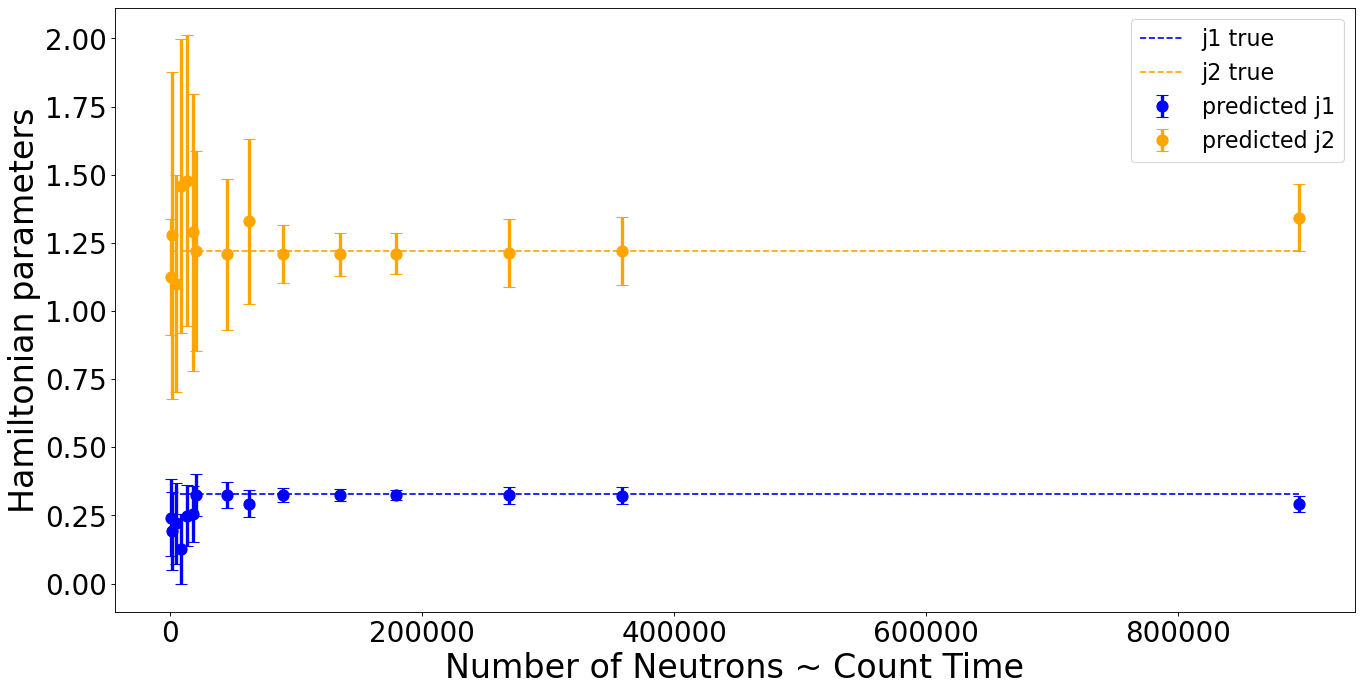

In [57]:
from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=80)

plt.errorbar(num_neutrons, np.median(preds[:,:,0],axis=1), np.std(preds[:,:,0],axis=1), fmt = 'o', ms = 10, elinewidth=3, capsize=5, barsabove=True, label = 'predicted j1', color = 'blue')
plt.errorbar(num_neutrons, np.median(preds[:,:,1],axis=1), np.std(preds[:,:,1],axis=1), fmt = 'o', ms = 10, elinewidth=3, capsize=5, barsabove=True, label = 'predicted j2', color = 'orange')
plt.plot(num_neutrons, 0.328*np.ones(num_neutrons.shape), "--", label = 'j1 true', color = 'blue')
plt.plot(num_neutrons, 1.2198*np.ones(num_neutrons.shape), "--", label = 'j2 true',  color = 'orange')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Number of Neutrons ~ Count Time', fontsize = 30)
plt.ylabel('Hamiltonian parameters', fontsize = 30)
plt.legend(fontsize=20)
plt.show()